In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import random
random.seed(9001)
from Levenshtein import distance as levenshtein_distance

### Preprocessing

In [2]:
data_dir = Path("../captcha_images_v2/captcha_images_v2")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'6', '5', '3', 'y', '7', 'm', 'w', '8', 'x', 'd', '2', '4', 'f', 'p', 'e', 'n', 'c', 'b', 'g'}


In [3]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
   
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(1)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(104)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

### Dataloaders for Active Learning

In [5]:
X_train = np.zeros(shape = (1, 200, 50, 1))
y_train = np.zeros(shape = (1, 5))

for i, item in enumerate(train_dataset):
    img = item['image']
    label = item['label']
    X_train = np.concatenate([X_train, img], axis = 0)
    y_train = np.concatenate([y_train, label], axis = 0)

In [6]:
X_train = X_train[1:]
y_train=y_train[1:]


### Initial data set selection and deletion from pool

In [7]:
initial_idx = np.array([],dtype=np.int)
idx = np.random.choice(len(X_train), size=100, replace=False)
initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

In [8]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

### Model

In [9]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
       
        # At test time, just return the computed predictions
        return loss


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
   

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.3)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3))(x)

    # Output layer
    output = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

   # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    model.trainable = True
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

### Helper function for Inference

In [10]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text
def cer(decode, target):
    return levenshtein_distance(decode,target)

In [11]:
def calc_acc():
    total_cer=0
    total_wer=0
    total_len=0
    Accuracy=0.0
    for batch in validation_dataset.take(104):
        batch_images = batch["image"]
        batch_labels = batch["label"]
        preds = model.predict(batch)
        num_of_examples = len(preds)
    
        pred_texts = decode_batch_predictions(preds)
    


    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    #preprocess to compare characters
    pred_texts1=[]
    for i in range(len(pred_texts)):
        str1=pred_texts[i]
        str1=str1.replace('[UNK]','z')
        pred_texts1.append(str1)  
 

    for j in range(num_of_examples):
        str1=orig_texts[j]
        str2=pred_texts1[j]
        total_cer += cer(str2, str1)
        total_len+=float(len(orig_texts[j]))
        if(str1==str2):
            total_wer += 1
        
    total_cor=total_len - total_cer
    print(total_cor,total_len) 
    Accuracy= (100 * total_cor)/total_len
    total_wer/= num_of_examples
    print('Word level accuracy :',total_wer*100,'%')
    print("Character level Accuracy at the end of acquisition",(Accuracy))
    return (total_wer*100,Accuracy)


### Training loop

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
epochs=250
acc=[]
characc=[]

In [13]:
def train_initial():
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        with tf.GradientTape() as tape:

            preds = model([X_initial,y_initial], training=True)  

            loss_value = CTCLayer(name="ctc_loss")(y_initial, preds)
                
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

     
    word,char=calc_acc()
    acc.append(word)
    characc.append(char)
        

In [14]:
train_initial()


Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4

Start of epoch 5

Start of epoch 6

Start of epoch 7

Start of epoch 8

Start of epoch 9

Start of epoch 10

Start of epoch 11

Start of epoch 12

Start of epoch 13

Start of epoch 14

Start of epoch 15

Start of epoch 16

Start of epoch 17

Start of epoch 18

Start of epoch 19

Start of epoch 20

Start of epoch 21

Start of epoch 22

Start of epoch 23

Start of epoch 24

Start of epoch 25

Start of epoch 26

Start of epoch 27

Start of epoch 28

Start of epoch 29

Start of epoch 30

Start of epoch 31

Start of epoch 32

Start of epoch 33

Start of epoch 34

Start of epoch 35

Start of epoch 36

Start of epoch 37

Start of epoch 38

Start of epoch 39

Start of epoch 40

Start of epoch 41

Start of epoch 42

Start of epoch 43

Start of epoch 44

Start of epoch 45

Start of epoch 46

Start of epoch 47

Start of epoch 48

Start of epoch 49

Start of epoch 50

Start of epoch 51

Start of epoch 52

St

### Parameters for Active Learning

In [15]:
Queries=15
epochs = 100
acquisition_iterations=20
dropout_iterations=100
nb_classes=20

### Random Sampling

In [ ]:
for i in range(acquisition_iterations):
        print('POOLING ITERATION NUMBER', i)
      
        x_pool_index = np.asarray(np.random.choice(len(X_pool), size=Queries, replace=False))

        Pooled_X = X_pool[x_pool_index, :, :, :]
        Pooled_Y = y_pool[x_pool_index]

        X_initial = np.concatenate((X_initial, Pooled_X), axis=0)
        y_initial = np.concatenate((y_initial, Pooled_Y), axis=0)
        #print(X_initial.shape)

        X_pool = np.delete(X_train, initial_idx, axis=0)
        y_pool = np.delete(y_train, initial_idx, axis=0)
       
        train_initial()

### Entropy

In [ ]:
for i in range(acquisition_iterations):
        print('POOLING ITERATION NUMBER', i)
      
        pool_subset = 100
        pool_subset_dropout = np.asarray(random.sample(range(0,X_pool.shape[0]), pool_subset))
        X_Pool_Dropout = X_pool[pool_subset_dropout, :, :, :]
        y_Pool_Dropout = y_pool[pool_subset_dropout]
        
        score_All = np.zeros(shape=(X_Pool_Dropout.shape[0],50))
        
        for d in range(dropout_iterations):
                    
            dropout_score = model.predict(X_Pool_Dropout,batch_size=16, verbose=1)  
            softmax_out = np.exp(dropout_score) / np.sum(np.exp(dropout_score), axis=1, keepdims=True)
            entropy = -np.sum(softmax_out * np.log(softmax_out), axis = 2)
            score_All = score_All + entropy
                    
        Avg_Pi = np.divide(score_All, dropout_iterations)
        Entropy_Average_Pi = np.mean(Avg_Pi, axis=-1)# consider mean or max of the slices
        a=Entropy_Average_Pi.flatten()
        index = a.argsort()[-Queries:][::-1]
           
        x_pool_index= pool_subset_dropout[index]   
        Pooled_X = X_pool[x_pool_index, :, :, :]
        Pooled_Y = y_pool[x_pool_index]

        X_initial = np.concatenate((X_initial, Pooled_X), axis=0)
        y_initial = np.concatenate((y_initial, Pooled_Y), axis=0)
        print(X_initial.shape)    

        X_pool = np.delete(X_train, initial_idx, axis=0)
        y_pool = np.delete(y_train, initial_idx, axis=0)
        
        train_initial()
            
            
        


### BALD

In [ ]:
for i in range(acquisition_iterations):
        print('POOLING ITERATION NUMBER', i)
      
        pool_subset = 100
        pool_subset_dropout = np.asarray(random.sample(range(0,X_pool.shape[0]), pool_subset))
        X_Pool_Dropout = X_pool[pool_subset_dropout, :, :, :]
        y_Pool_Dropout = y_pool[pool_subset_dropout]
        
        score_All = np.zeros(shape=(X_Pool_Dropout.shape[0],50))
        All_Entropy_Dropout = np.zeros(shape=(X_Pool_Dropout.shape[0],50))

        
        for d in range(dropout_iterations):
           
            dropout_score = model.predict(X_Pool_Dropout,batch_size=16, verbose=1)
            softmax_out = np.exp(dropout_score) / np.sum(np.exp(dropout_score), axis=1, keepdims=True)
            entropy = -np.sum(softmax_out * np.log(softmax_out), axis = 2)
            score_All = score_All + entropy
            Entropy_Per_Dropout = np.mean(entropy, axis=-1)
            

       
        Avg_Pi = np.divide(score_All, dropout_iterations)
        Entropy_Average_Pi = np.mean(Avg_Pi, axis=-1)# consider mean of the slices
       
        
     
        gain= Entropy_Average_Pi - Entropy_Per_Dropout
       
       
        index = gain.argsort()[-Queries:][::-1]
         
        x_pool_index= pool_subset_dropout[index] 
        print(x_pool_index)
        Pooled_X = X_pool[x_pool_index, :, :, :]
        Pooled_Y = y_pool[x_pool_index]

        X_initial = np.concatenate((X_initial, Pooled_X), axis=0)
        y_initial = np.concatenate((y_initial, Pooled_Y), axis=0)
        print(X_initial.shape)    

        X_pool = np.delete(X_train, initial_idx, axis=0)
        y_pool = np.delete(y_train, initial_idx, axis=0)
        
        train_initial()


### VarRatio

In [ ]:
for i in range(acquisition_iterations):
        print('POOLING ITERATION NUMBER', i)
      
        pool_subset = 100
        pool_subset_dropout = np.asarray(random.sample(range(0,X_pool.shape[0]), pool_subset))
        X_Pool_Dropout = X_pool[pool_subset_dropout, :, :, :]
        y_Pool_Dropout = y_pool[pool_subset_dropout]
        All_Dropout_Scores = np.zeros(shape=(X_Pool_Dropout.shape[0],20))
        
        for d in range(dropout_iterations):
          
            dropout_score = model.predict(X_Pool_Dropout,batch_size=16, verbose=1)
            softmax_out = np.exp(dropout_score) / np.sum(np.exp(dropout_score), axis=1, keepdims=True)
            dropout_score=np.mean(dropout_score,axis=1)#take mean of slices
          
            predicted = tf.argmax(dropout_score, axis=1)
            
            dropout_classes = np.array([predicted]).T
            All_Dropout_Scores = np.append(All_Dropout_Scores, dropout_classes, axis=1)
            
        
        Variation = np.zeros(shape=(X_Pool_Dropout.shape[0]))

        for t in range(X_Pool_Dropout.shape[0]): #samples
            L = np.array([0])
            for d_iter in range(100): # no of dropouts
                L = np.append(L, All_Dropout_Scores[t, d_iter+1]) # class labels for a sample in a row
                
            Predicted_Class, Mode = mode(L[1:]) # calculate the mode
            #print(Predicted_Class, Mode)
            v = np.array(  [1 - Mode/float(100)])# variation=(1-mode/dropout iterations)
            Variation[t] = v
            
        a_1d = Variation.flatten()
        index = a_1d.argsort()[-Queries:][::-1]
        
        
        x_pool_index= pool_subset_dropout[index]  
        #print(x_pool_index)
        Pooled_X = X_pool[x_pool_index, :, :, :]
        Pooled_Y = y_pool[x_pool_index]

        X_initial = np.concatenate((X_initial, Pooled_X), axis=0)
        y_initial = np.concatenate((y_initial, Pooled_Y), axis=0)
        print(X_initial.shape)    

        X_pool = np.delete(X_train, initial_idx, axis=0)
        y_pool = np.delete(y_train, initial_idx, axis=0)
        
        train_loop()    
            


### Standard Deviation

In [ ]:
for i in range(acquisition_iterations):
        print('POOLING ITERATION NUMBER', i)
      
        pool_subset = 100
        pool_subset_dropout = np.asarray(random.sample(range(0,X_pool.shape[0]), pool_subset))
        X_Pool_Dropout = X_pool[pool_subset_dropout, :, :, :]
        y_Pool_Dropout = y_pool[pool_subset_dropout]
        All_Dropout_Scores = np.zeros(shape=(X_Pool_Dropout.shape[0],50, nb_classes))
        
        for d in range(dropout_iterations):
         
            dropout_score = model.predict(X_Pool_Dropout,batch_size=16, verbose=0)
            softmax_out = np.exp(dropout_score) / np.sum(np.exp(dropout_score), axis=1, keepdims=True)
           
            All_Dropout_Scores = np.append(All_Dropout_Scores, dropout_score, axis=2)
       
            
            
            
        All_Std = np.zeros(shape=(X_Pool_Dropout.shape[0],50,nb_classes))
        check = np.zeros(shape=(X_Pool_Dropout.shape[0],50))
        BayesSegnet_Sigma = np.zeros(shape=(X_Pool_Dropout.shape[0],1))
        M= np.zeros(shape=(X_Pool_Dropout.shape[0],50))
        
       
        for t in range(X_Pool_Dropout.shape[0]):#samples considered
            for i in range(50):
                for r in range(nb_classes):# 20 classes 
                    L = np.array([0])#initialize
                    for d_iter in range(dropout_iterations):
                        L = np.append(L, All_Dropout_Scores[t,i, r+nb_classes])#prob for each sample per iteration and class
                        #print(L.shape)

                    L_std = np.std(L[1:])#standard deviation per class
                
                    All_Std[t,i,r] = L_std#std dev for all 20 classes
               
            check = np.sum(All_Std,axis=2)
           
            E = np.mean(check,axis=1)#consider mean of slice
            BayesSegnet_Sigma = E# std deviation per sample
            
        
        a_1d = BayesSegnet_Sigma.flatten()
        index = a_1d.argsort()[-Queries:][::-1]
        
        
        x_pool_index= pool_subset_dropout[index]  
        #print(x_pool_index)
        Pooled_X = X_pool[x_pool_index, :, :, :]
        Pooled_Y = y_pool[x_pool_index]

        X_initial = np.concatenate((X_initial, Pooled_X), axis=0)
        y_initial = np.concatenate((y_initial, Pooled_Y), axis=0)
        print(X_initial.shape)    

        X_pool = np.delete(X_train, initial_idx, axis=0)
        y_pool = np.delete(y_train, initial_idx, axis=0)
        
        train_loop()
        
    

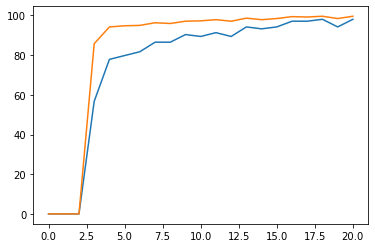

In [18]:
plt.plot(acc,label="Word level Acc")
plt.plot(characc, label="Char level Acc")
plt.legend()

In [18]:
np.save('Accuracy_randomaocrexp22.npy',acc)
np.save('CharAccuracy_randomaocrexp22.npy',characc)
#from IPython.display import FileLink
#FileLink("./randomocrexp1.sav")

In [21]:
model.save('randomaocrexp22.h5')